[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15488\479049715.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = data.drop(['Date', 'Adj Close'], axis=1)


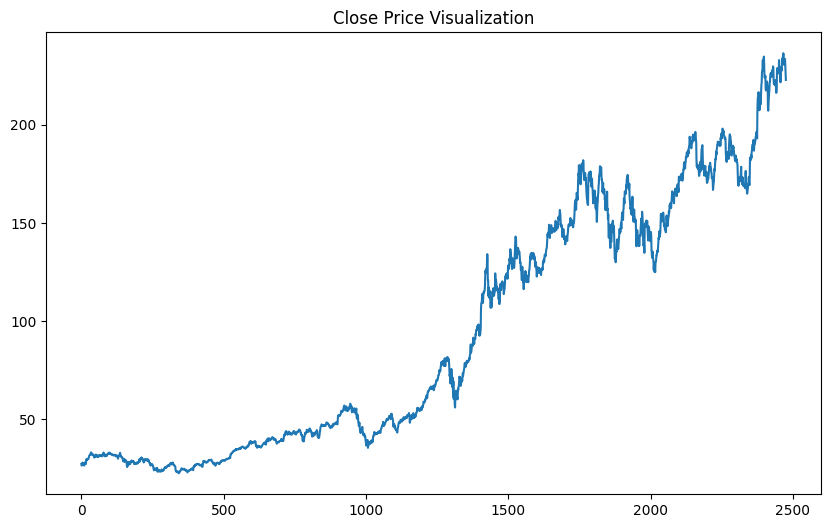

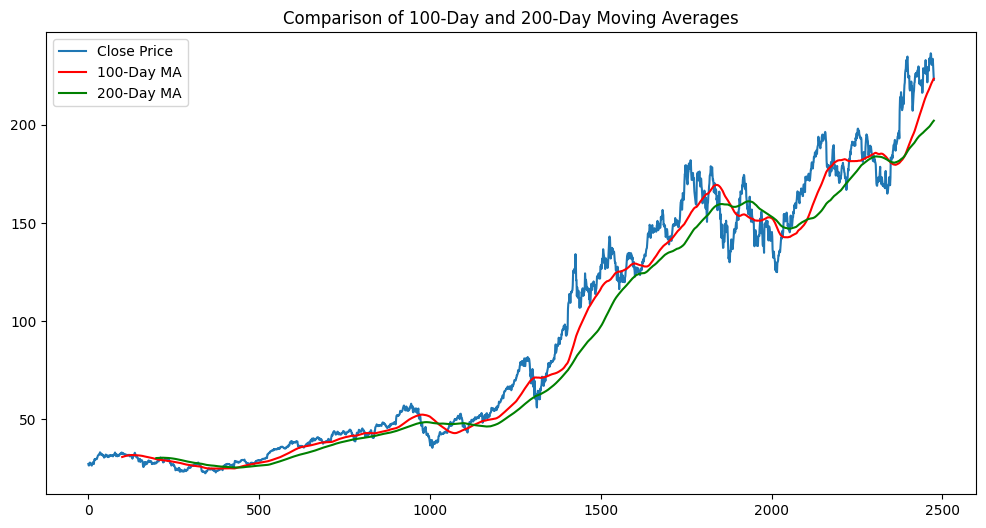

Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - MAE: 0.1731 - loss: 0.0739 - val_MAE: 0.0711 - val_loss: 0.0080
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - MAE: 0.0644 - loss: 0.0095 - val_MAE: 0.0419 - val_loss: 0.0040
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - MAE: 0.0589 - loss: 0.0082 - val_MAE: 0.0494 - val_loss: 0.0044
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - MAE: 0.0567 - loss: 0.0070 - val_MAE: 0.0266 - val_loss: 0.0014
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - MAE: 0.0422 - loss: 0.0048 - val_MAE: 0.0273 - val_loss: 0.0015
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - MAE: 0.0416 - loss: 0.0047 - val_MAE: 0.0311 - val_loss: 0.0017
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - MAE: 0.0422 - loss: 0.0044 - val_MAE: 0.0239 - val_loss: 0.0013
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - MAE: 0.0420 - loss: 0.0046 - val_MAE: 0.0407 - val_loss: 0.0034
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - MAE: 0.0441 

In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error

# Set start and end dates
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

# Load data
data = load_data('AAPL')
df = data.drop(['Date', 'Adj Close'], axis=1)

# Plot Close Price
plt.figure(figsize=(10, 6))
plt.title("Close Price Visualization")
plt.plot(df.Close)
plt.show()

# Calculate Moving Averages
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df.Close, label='Close Price')
plt.plot(ma100, 'r', label='100-Day MA')
plt.plot(ma200, 'g', label='200-Day MA')
plt.title('Comparison of 100-Day and 200-Day Moving Averages')
plt.legend()
plt.show()

# Split data into training and testing sets
train = data[0:int(len(data)*0.70)]
test = data[int(len(data)*0.70):]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_close = train['Close'].values.reshape(-1, 1)
test_close = test['Close'].values.reshape(-1, 1)
data_training_array = scaler.fit_transform(train_close)

# Prepare training data
x_train = []
y_train = []
for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=60, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(units=80, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(units=120, activation='relu'),
    Dropout(0.5),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

# Prepare testing data
input_data = scaler.transform(data['Close'].values.reshape(-1, 1))
x_test = []
y_test = []
for i in range(100, len(input_data) - len(test)):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

# Predict and calculate Mean Absolute Error
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on test set:", mae)
